### [Langfuse Datasets](https://langfuse.com/guides/cookbook/datasets)

we’ll iterate on systems prompts with the goal of getting only the capital of a given country. We use Langfuse datasets, to store a list of example inputs and expected outputs.

- Dataset is a collection of DatasetItems
  - DatasetItem contains input, expected_output, and metadata
- DatasetRun is an experiment run on a Dataset, it is identified by a unique name
  - DatasetRunItem links a DatasetItem to a Trace created during an experiment
  - Evaluation metrics of a DatasetRun are based on Scores associated with the Traces linked to run


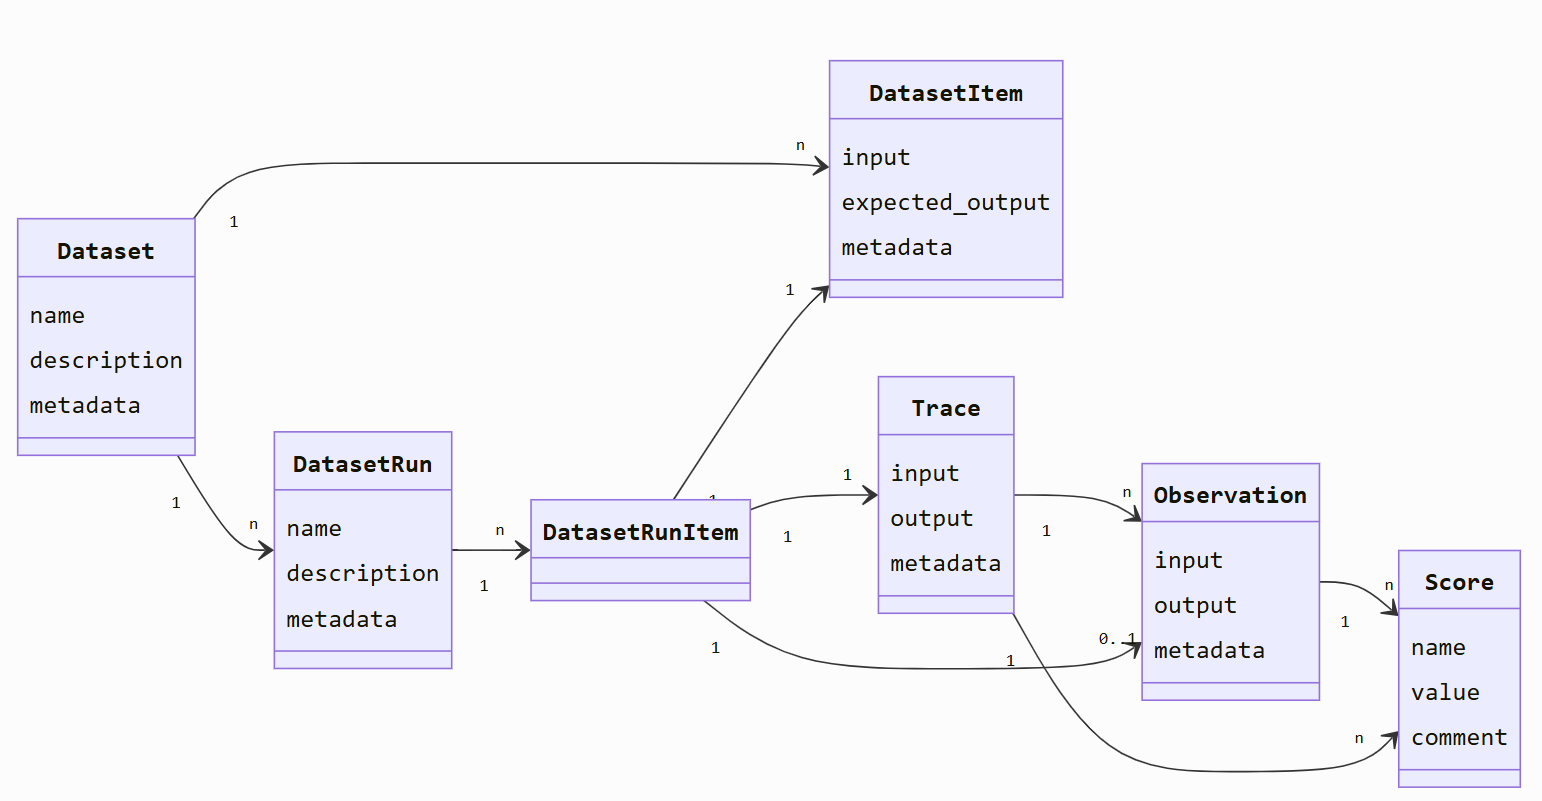


#### Setup


In [ ]:
%pip install langfuse openai langchain_openai langchain --upgrade

In [25]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
LANGFUSE_HOST = "http://localhost:3000"

# Your openai key
os.environ["OPENAI_API_KEY"] = (
    "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"
)

With the environment variables set, we can now initialize the Langfuse client. get_client() initializes the Langfuse client using the credentials provided in the environment variables.


In [ ]:
from langfuse import get_client

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


#### Create a dataset


In [ ]:
langfuse.create_dataset(name="capital_cities")

#### Items

Load local items into the Langfuse dataset. Alternatively you can add items from production via the Langfuse UI.


In [8]:
# example items, could also be json instead of strings
local_items = [
    {"input": {"country": "Italy"}, "expected_output": "Rome"},
    {"input": {"country": "Spain"}, "expected_output": "Madrid"},
    {"input": {"country": "Brazil"}, "expected_output": "Brasília"},
    {"input": {"country": "Japan"}, "expected_output": "Tokyo"},
    {"input": {"country": "India"}, "expected_output": "New Delhi"},
    {"input": {"country": "Canada"}, "expected_output": "Ottawa"},
    {"input": {"country": "South Korea"}, "expected_output": "Seoul"},
    {"input": {"country": "Argentina"}, "expected_output": "Buenos Aires"},
    {"input": {"country": "South Africa"}, "expected_output": "Pretoria"},
    {"input": {"country": "Egypt"}, "expected_output": "Cairo"},
]

In [ ]:
# Upload to Langfuse
for item in local_items:
    langfuse.create_dataset_item(
        dataset_name="capital_cities",
        # any python object or value
        input=item["input"],
        # any python object or value, optional
        expected_output=item["expected_output"],
    )

### Example using Langfuse @observe() decorator


#### Application


This an example production application that we want to evaluate. It is instrumented with the Langfuse Decorator. We do not need to change the application code to evaluate it subsequently.


In [ ]:
# from langfuse.openai import openai
from langfuse.openai import OpenAI
from langfuse import observe, get_client

langfuse = get_client()

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key="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",
)


@observe()
def run_my_custom_llm_app(input, system_prompt):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": input["country"]},
    ]

    completion = (
        client.chat.completions.create(
            model="deepseek/deepseek-chat", messages=messages
        )
        .choices[0]
        .message.content
    )

    # Explicitly set trace input/output for evaluation features
    langfuse.update_current_trace(input=input, output=completion)

    return completion

#### Experiment runner


This is a simple experiment runner that runs the application on each item in the dataset and evaluates the output.


In [ ]:
# we use a very simple eval here, you can use any eval library
# see https://langfuse.com/docs/scores/model-based-evals for details
# you can also use LLM-as-a-judge managed within Langfuse to evaluate the outputs


def simple_evaluation(output, expected_output):
    return output == expected_output

In [ ]:
def run_experiment(experiment_name, system_prompt):
    dataset = langfuse.get_dataset("capital_cities")

    for item in dataset.items:

        # Use the item.run() context manager
        with item.run(
            run_name=experiment_name,
        ) as root_span:  # root_span is the root span of the new trace for this item and run.
            # All subsequent langfuse operations within this block are part of this trace.

            # Call your application logic
            output = run_my_custom_llm_app(item.input, system_prompt)

            # Optionally, score the result against the expected output
            root_span.score_trace(
                name="exact_match",
                value=simple_evaluation(output, item.expected_output),
            )

    print(
        f"\nFinished processing dataset 'capital_cities' for run '{experiment_name}'."
    )

#### Run experiments


Now we can easily run experiments with different configurations to explore which yields the best results.


In [ ]:
from langfuse import get_client

langfuse = get_client()

run_experiment(
    "famous_city",
    "The user will input countries, respond with the most famous city in this country",
)
run_experiment("directly_ask", "What is the capital of the following country?")
run_experiment(
    "asking_specifically",
    "The user will input countries, respond with only the name of the capital",
)
run_experiment(
    "asking_specifically_2nd_try",
    "The user will input countries, respond with only the name of the capital. State only the name of the city.",
)

# Assert that all events were sent to the Langfuse API
langfuse.flush()
langfuse.flush()


Finished processing dataset 'capital_cities' for run 'famous_city'.

Finished processing dataset 'capital_cities' for run 'directly_ask'.

Finished processing dataset 'capital_cities' for run 'asking_specifically'.

Finished processing dataset 'capital_cities' for run 'asking_specifically_2nd_try'.


#### Example using Langchain


关键特点：
Langchain 集成：使用 ChatOpenAI + ChatPromptTemplate + chain 构建 LLM 应用
双重追踪：
Langfuse 的 start_as_current_span 创建主追踪,
Langchain 的 CallbackHandler 追踪链条执行细节
实验对比：针对同一数据集，测试不同的 system prompt 效果
自动评分：每次运行后自动评估输出质量（exact_match）
与前面 @observe() 装饰器方法的区别：
前面：直接用 OpenAI 客户端 + @observe() 装饰器
这里：用 Langchain 框架 + CallbackHandler + start_as_current_span
两种方法都能实现 LLM 应用的追踪和评估，但 Langchain 方法更适合复杂的 LLM 应用场景。


In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage


def run_my_langchain_llm_app(input, system_message, callback_handler):

    # Create a trace via Langfuse spans and use Langchain within it
    with langfuse.start_as_current_span(name="my-langchain-agent") as root_span:

        prompt = ChatPromptTemplate.from_messages(
            [("system", system_message), MessagesPlaceholder(variable_name="messages")]
        )

        # chat = ChatOpenAI()

        # Use OpenRouter as the base URL for the ChatOpenAI client
        chat = ChatOpenAI(
            api_key=os.environ.get("OPENAI_API_KEY"),
            base_url="https://openrouter.ai/api/v1",
            model="deepseek/deepseek-chat",
        )
        chain = prompt | chat

        result = chain.invoke(
            {"messages": [HumanMessage(content=input)]},
            config={"callbacks": [callback_handler]},
        )

        # Update trace output
        root_span.update_trace(input=input, output=result.content)

    return result.content

In [ ]:
from langfuse.langchain import CallbackHandler


def run_langchain_experiment(experiment_name, system_prompt):

    dataset = langfuse.get_dataset("capital_cities")

    # Initialize the Langfuse handler
    langfuse_handler = CallbackHandler()

    for item in dataset.items:

        # Use the item.run() context manager
        with item.run(
            run_name=experiment_name,
            run_description="My first run",
            run_metadata={"model": "deepseek/deepseek-chat"},
        ) as root_span:  # root_span is the root span of the new trace for this item and run.
            # All subsequent langfuse operations within this block are part of this trace.

            # Call your application logic
            output = run_my_langchain_llm_app(
                item.input["country"], system_prompt, langfuse_handler
            )

            # Optionally, score the result against the expected output
            root_span.score_trace(
                name="exact_match",
                value=simple_evaluation(output, item.expected_output),
            )

    print(
        f"\nFinished processing dataset 'capital_cities' for run '{experiment_name}'."
    )

[langchain_famous_city](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/a8db1513922f26d8a0494733a77d3c59?observation=dde0afe1013b4dde)

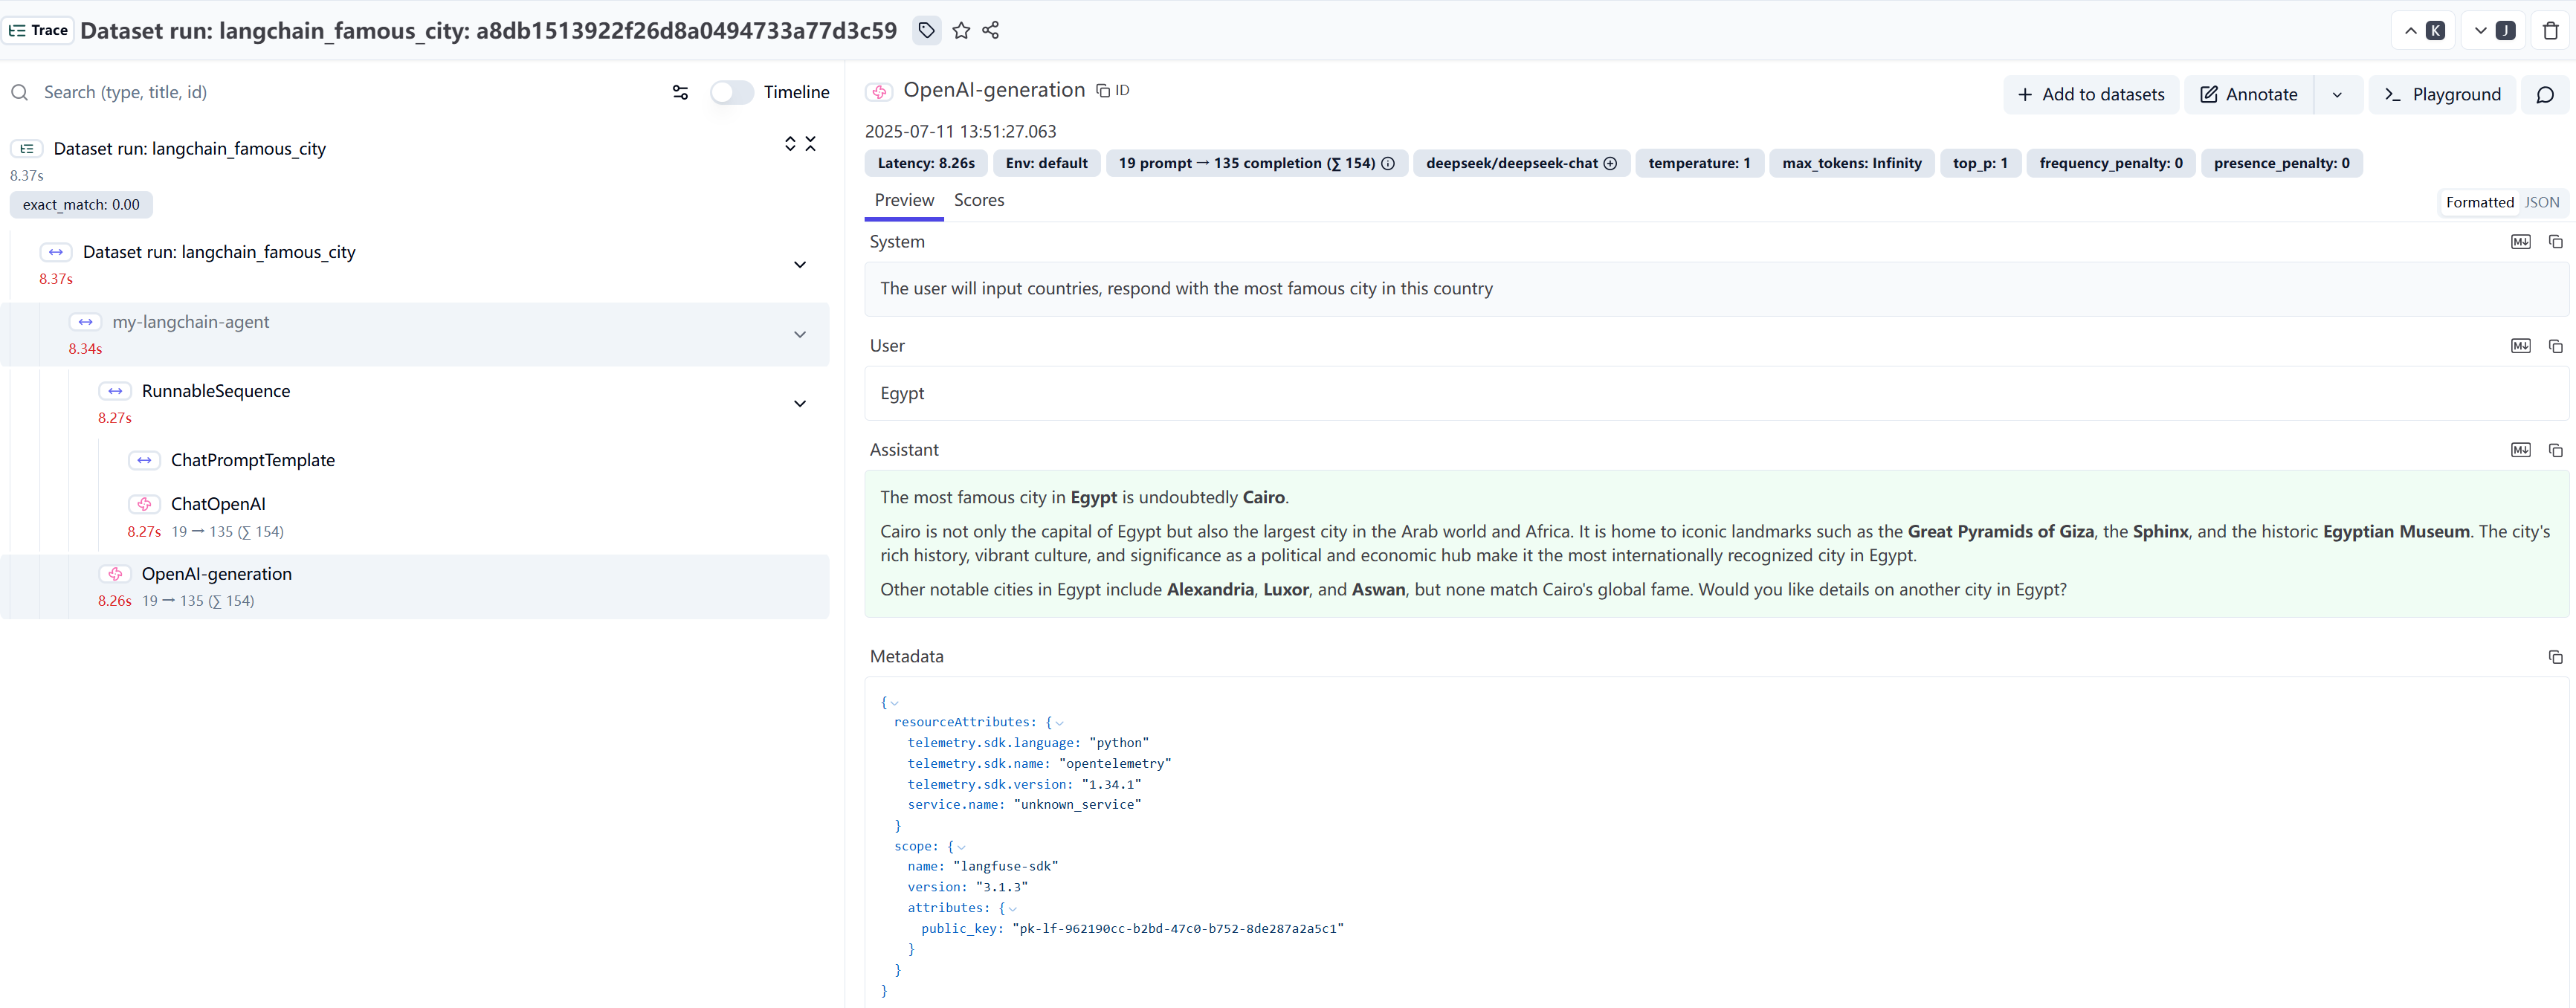

In [ ]:
run_langchain_experiment(
    "langchain_famous_city",
    "The user will input countries, respond with the most famous city in this country",
)
run_langchain_experiment(
    "langchain_directly_ask", "What is the capital of the following country?"
)
run_langchain_experiment(
    "langchain_asking_specifically",
    "The user will input countries, respond with only the name of the capital",
)
run_langchain_experiment(
    "langchain_asking_specifically_2nd_try",
    "The user will input countries, respond with only the name of the capital. State only the name of the city.",
)

[langchain_experiment](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/datasets/cmcy9mi0e005hph06mow1ee94/compare?runs=cmcydyaxo00adph06rg061jio&runs=cmcyakkrr0099ph06ca1j72cr&runs=cmcyak3k00085ph06bqj0693r&runs=cmcyaj8al0071ph06xzo3h6qd)


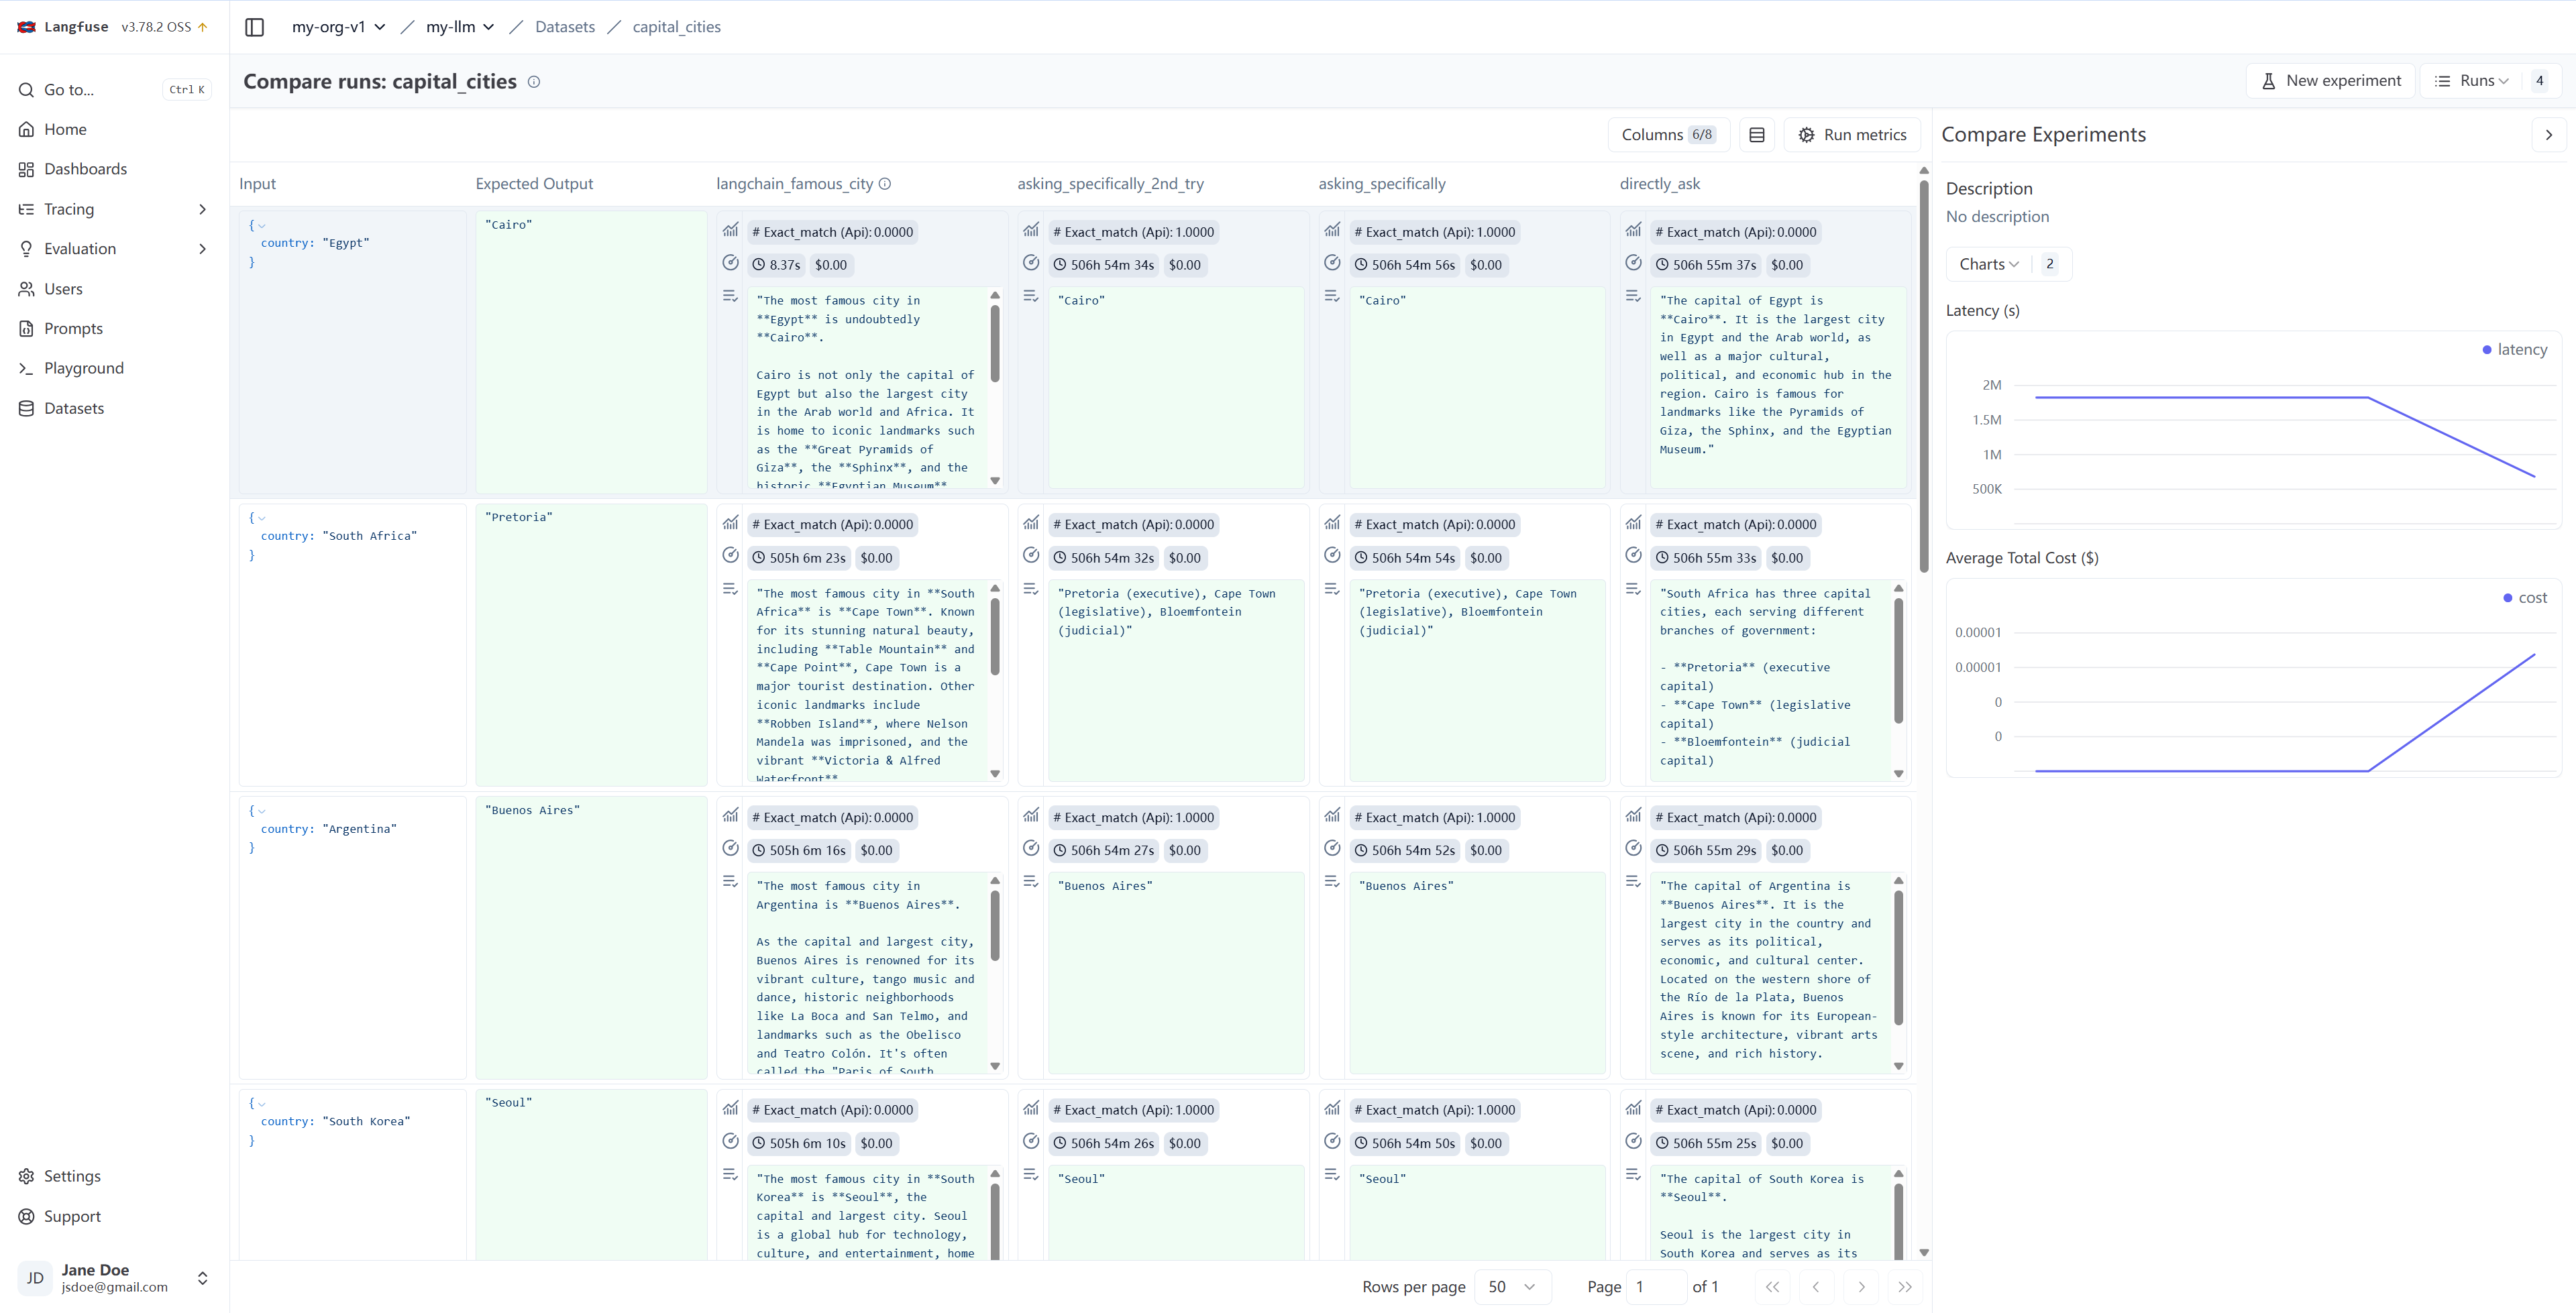

### More Examples

- LangGraph Dataset Experiment
- OpenAI Agents SDK Dataset Experiment
- CrewAI Dataset Experiment
- Smolagents Dataset Experiment


In [ ]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
LANGFUSE_HOST = "http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"

#### LangGraph Dataset Experiment [Offline Evaluation](https://langfuse.com/guides/cookbook/example_langgraph_agents#offline-evaluation)

**Offline Evaluation**

Online evaluation is essential for live feedback, but you also need offline evaluation—systematic checks before or during development. This helps maintain quality and reliability before rolling changes into production.

**Dataset Evaluation**

In offline evaluation, you typically:

1. Have a benchmark dataset (with prompt and expected output pairs)
2. Run your agent on that dataset
3. Compare outputs to the expected results or use an additional scoring mechanism
   Below, we demonstrate this approach with the q&a-dataset, which contains questions and expected answers.

Below, we demonstrate this approach with the [q&a-dataset](https://huggingface.co/datasets/junzhang1207/search-dataset), which contains questions and expected answers.


In [1]:
import os

os.environ["STREAMING"] = "true"
os.environ["HF_DATASETS_CACHE"] = "E:/data/huggingface/datasets"
os.environ["HF_DATASETS_IN_MEMORY_MAX_SIZE"] = "1000000000"


import pandas as pd
from datasets import load_dataset

dataset = load_dataset("junzhang1207/search-dataset", split="train")
df = pd.DataFrame(dataset)

print(df.head())

README.md: 0.00B [00:00, ?B/s]

e:\conda\envs\langfuse\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in E:\data\huggingface\hub\datasets--junzhang1207--search-dataset. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


                                     id  \
0  20caf138-0c81-4ef9-be60-fe919e0d68d4   
1  1f37d9fd-1bcc-4f79-b004-bc0e1e944033   
2  76173a7f-d645-4e3e-8e0d-cca139e00ebe   
3  5f5ef4ca-91fe-4610-a8a9-e15b12e3c803   
4  64dbed0d-d91b-4acd-9a9c-0a7aa83115ec   

                                            question  \
0                 steve jobs statue location budapst   
1  Why is the Battle of Stalingrad considered a t...   
2  In what year did 'The Birth of a Nation' surpa...   
3  How many Russian soldiers surrendered to AFU i...   
4   What event led to the creation of Google Images?   

                                     expected_answer       category       area  
0  The Steve Jobs statue is located in Budapest, ...           Arts  Knowledge  
1  The Battle of Stalingrad is considered a turni...   General News       News  
2  This question is based on a false premise. 'Th...  Entertainment       News  
3  About 300 Russian soldiers surrendered to the ...   General News       News  

Next, we create a dataset entity in Langfuse to track the runs. Then, we add each item from the dataset to the system.


In [2]:
from langfuse import get_client

client = get_client()

langfuse_dataset_name = "qa-dataset_langgraph-agent"

# Create a new dataset in Langfuse
dataset = client.create_dataset(
    name=langfuse_dataset_name,
    description="q&a dataset uploaded from Hugging Face",
    metadata={"date": "2025-08-05", "type": "benchmark"},
)

In [ ]:
df_30 = df.sample(30)  # For this example, we only take 30 dataset questions

for idx, row in df_30.iterrows():
    client.create_dataset_item(
        dataset_name=langfuse_dataset_name,
        input={"text": row["question"]},
        expected_output={"text": row["expected_answer"]},
    )

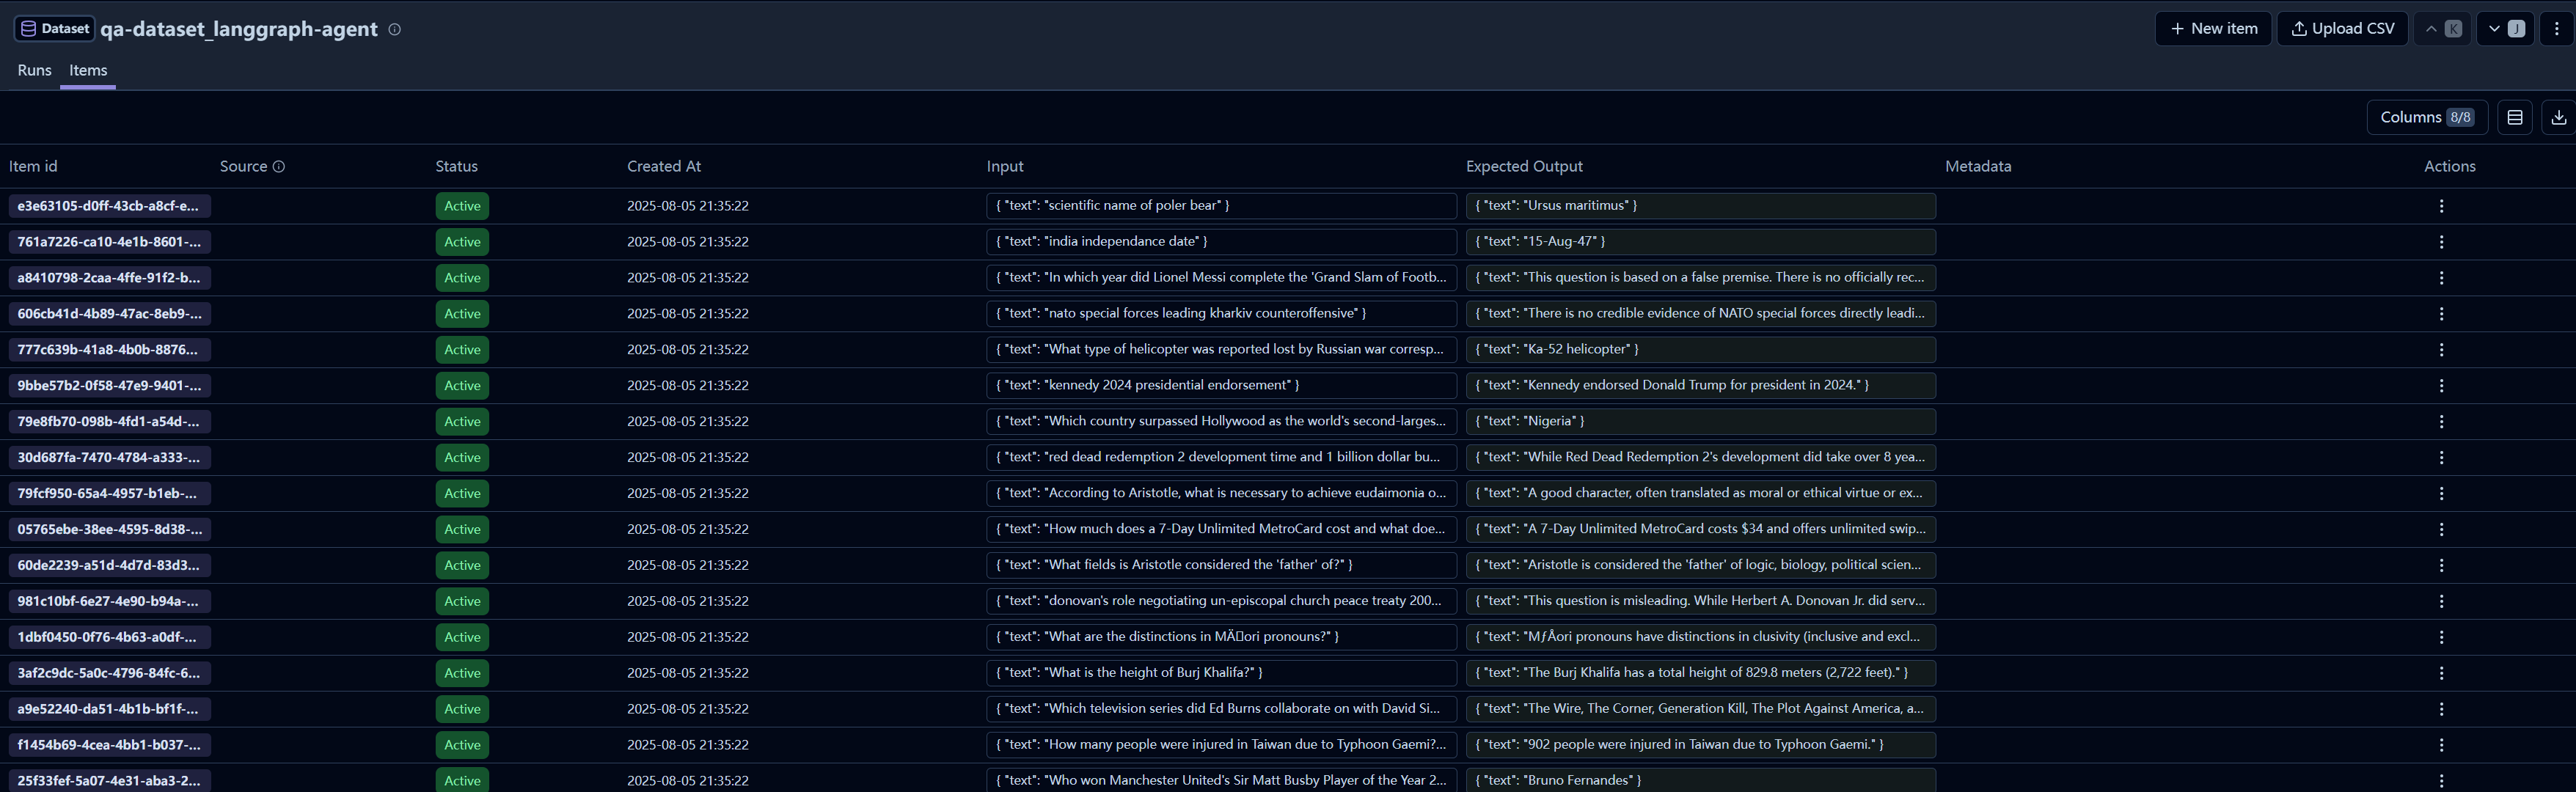


#### Running the Agent on the Dataset

First, we assemble a simple LangGraph agent that answers questions using OpenAI models.


In [12]:
%pip install langfuse langchain langgraph langchain_openai langchain_community langchain_huggingface

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
     -------- ------------------------------- 0.5/2.5 MB 493.7 kB/s eta 0:00:05
     -------- ------------------------------- 0.5/2.5 MB 493.7 kB/s eta 0:00:05
     ------------ --------------------------- 0.8/2.5 MB 524.3 kB/s eta 0:00:04
     ------------ --------------------------- 0.8/2.5 MB 524.3 kB/s eta 0:00:04
     ---------------- ----------------------- 1.0/2.5 MB 578.7 kB/s eta 0:00:03
     ---------------- ----------------------- 1.0/2.5 MB 578.7 kB/s eta 0:00:03
     -------------------- ------------------- 1.3/2.5 MB 564.1 kB/s eta 0:00:03
     -------------------

In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# llm = ChatOpenAI(model="-", temperature=0.7, streaming=True)
llm = ChatOpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url="https://api.siliconflow.cn",
    # model="Qwen/Qwen3-8B"
    # model="BAAI/bge-m3"
    # model="deepseek-ai/DeepSeek-V3"
    model="THUDM/GLM-4-9B-0414",
)


def chatbot(state: State) -> str:
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

Then, we define a helper function my_agent() that:

1. Creates a Langfuse trace
2. Fetches the langfuse_handler_trace to instrument the LangGraph execution.
3. Runs our agent and passing langfuse_handler_trace to the invocation.


In [ ]:
from langfuse import get_client
from langfuse.langchain import CallbackHandler
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
# llm = ChatOpenAI(model="-", temperature=0.7, streaming=True)
llm = ChatOpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
    base_url="https://api.siliconflow.cn",
    # model="Qwen/Qwen3-8B"
    # model="BAAI/bge-m3"
    # model="deepseek-ai/DeepSeek-V3"
    model="THUDM/GLM-4-9B-0414",
)
langfuse = get_client()


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()


def my_agent(question, langfuse_handler):

    # Create a trace via Langfuse spans and use Langchain with it
    with langfuse.start_as_current_span(name="my-langgraph-agent") as root_span:

        # Langchain processing
        response = graph.invoke(
            input={"messages": [HumanMessage(content=question)]},
            config={"callbacks": [langfuse_handler]},
        )

        # Update trace output
        root_span.update_trace(input=question, output=response["messages"][1].content)

        print(question)
        print(response["messages"][1].content)
    return response["messages"][1].content

[lang graph](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/bfff706f0716ac65ff065ab8ff38953e?view=preview&observation=33eb06a124a89ee7)

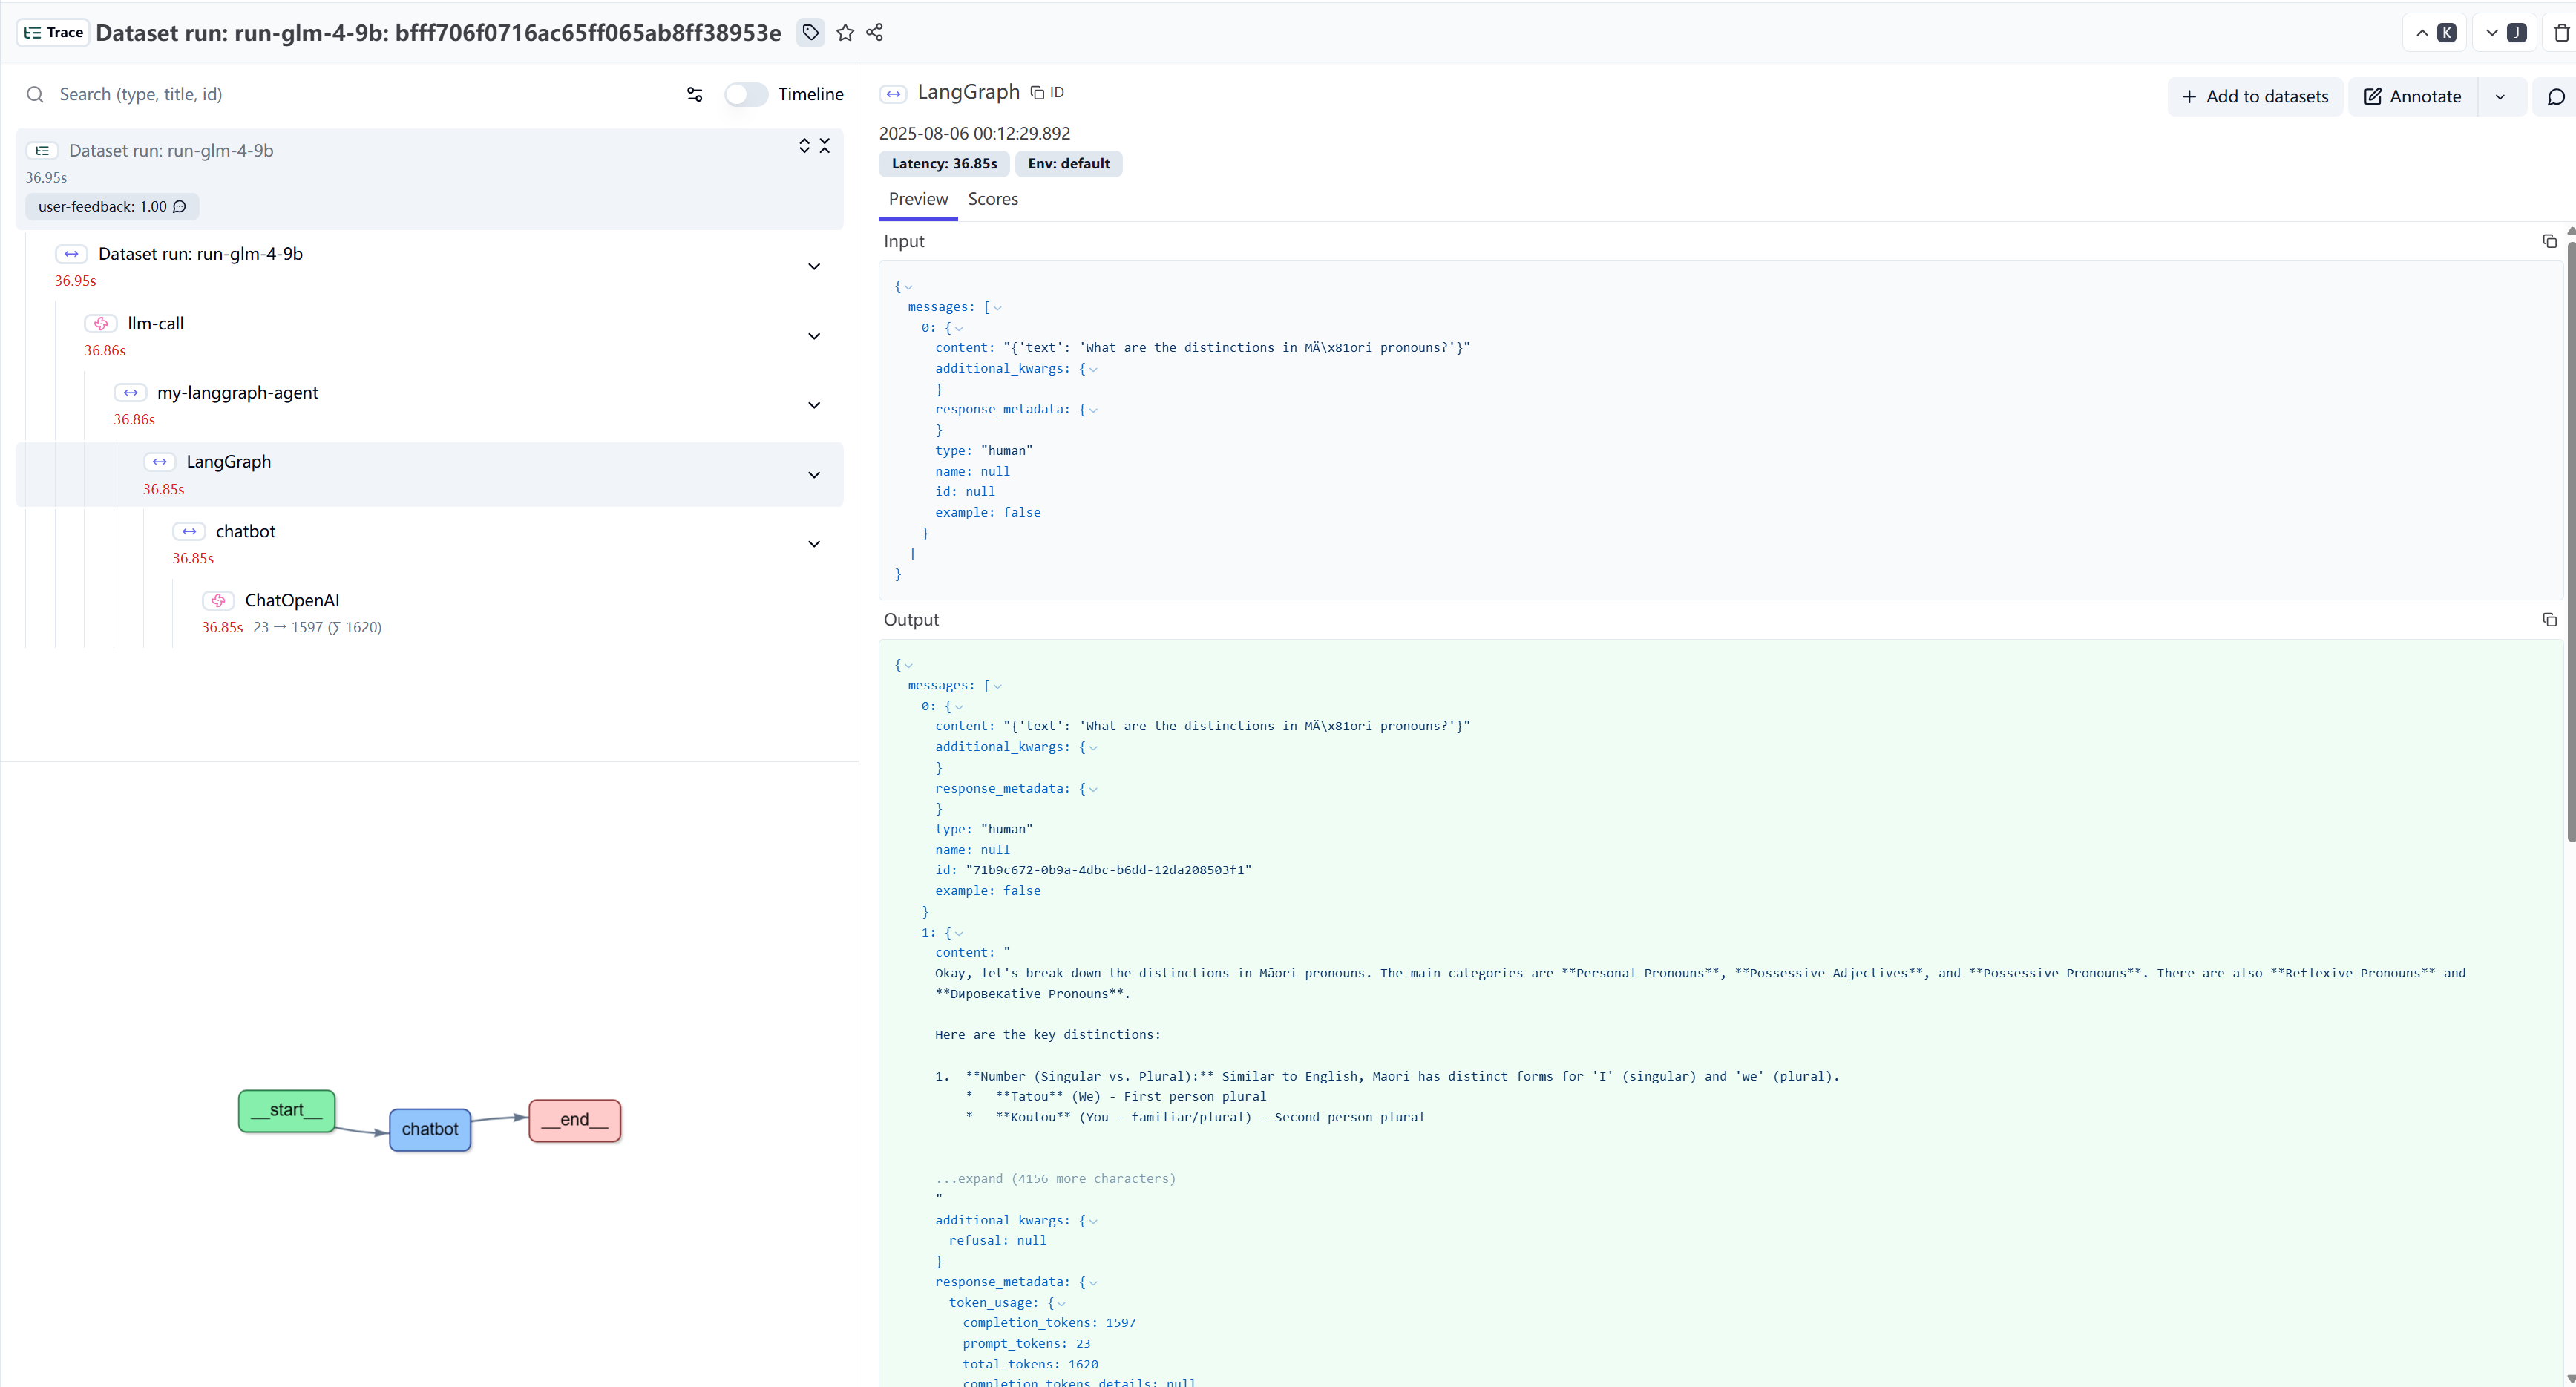

Finally, we loop over each dataset item, run the agent, and link the trace to the dataset item. We can also attach a quick evaluation score if desired.


In [ ]:
from langfuse import get_client
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()
langfuse = get_client()

dataset = langfuse.get_dataset("qa-dataset_langgraph-agent")

for item in dataset.items:
    # Use the item.run() context manager for automatic trace linking
    with item.run(
        # run_name="run-qwen3-8b",
        # run_name="run-bge-m3",
        # run_name="run-deepseek-v3",
        run_name="run-glm-4-9b",
        run_description="Running LangGraph agent on dataset",
        # run_metadata={"model": "Qwen/Qwen3-8B"},
        # run_metadata={"model": "BAAI/bge-m3"},
        # run_metadata={"model": "deepseek-ai/DeepSeek-V3"},
        run_metadata={"model": "THUDM/GLM-4-9B-0414"},
    ) as root_span:
        with langfuse.start_as_current_generation(
            # name="llm-call", model="Qwen/Qwen3-8B", input=item.input
            # name="llm-call", model="BAAI/bge-m3", input=item.input
            # name="llm-call", model="deepseek-ai/DeepSeek-V3", input=item.input
            name="llm-call",
            model="THUDM/GLM-4-9B-0414",
            input=item.input,
        ) as generation:
            # LLM application logic here
            output = my_agent(str(item.input), langfuse_handler)
            generation.update(output=output)

        # Optionally, score the result against the expected output
        root_span.score_trace(
            name="user-feedback",
            value=1,
            comment="This is a comment",  # optional, useful to add reasoning
        )

# Flush the langfuse client to ensure all data is sent to the server at the end of the experiment run
langfuse.flush()

{'text': 'scientific name of poler bear'}

It seems there might be a typo in your query. The word "poler" is not related to any known animal. Did you perhaps mean "polar" bear?

The scientific name for the polar bear is **Ursus maritimus**.
{'text': 'india independance date'}

**August 15, 1947**
{'text': "In which year did Lionel Messi complete the 'Grand Slam of Football' by winning the FIFA Club World Cup, thus becoming the first player to win every major trophy available in the sport?"}

The answer is **2009**. Lionel Messi won the FIFA Club World Cup that year with Barcelona.
{'text': 'nato special forces leading kharkiv counteroffensive'}

If NATO special forces are leading a counteroffensive in Kharkiv, it would be a significant development in the ongoing Russian invasion of Ukraine. This involvement would suggest a high level of military coordination and a substantial commitment from NATO. It is important to note that the involvement of NATO troops in direct combat operations h

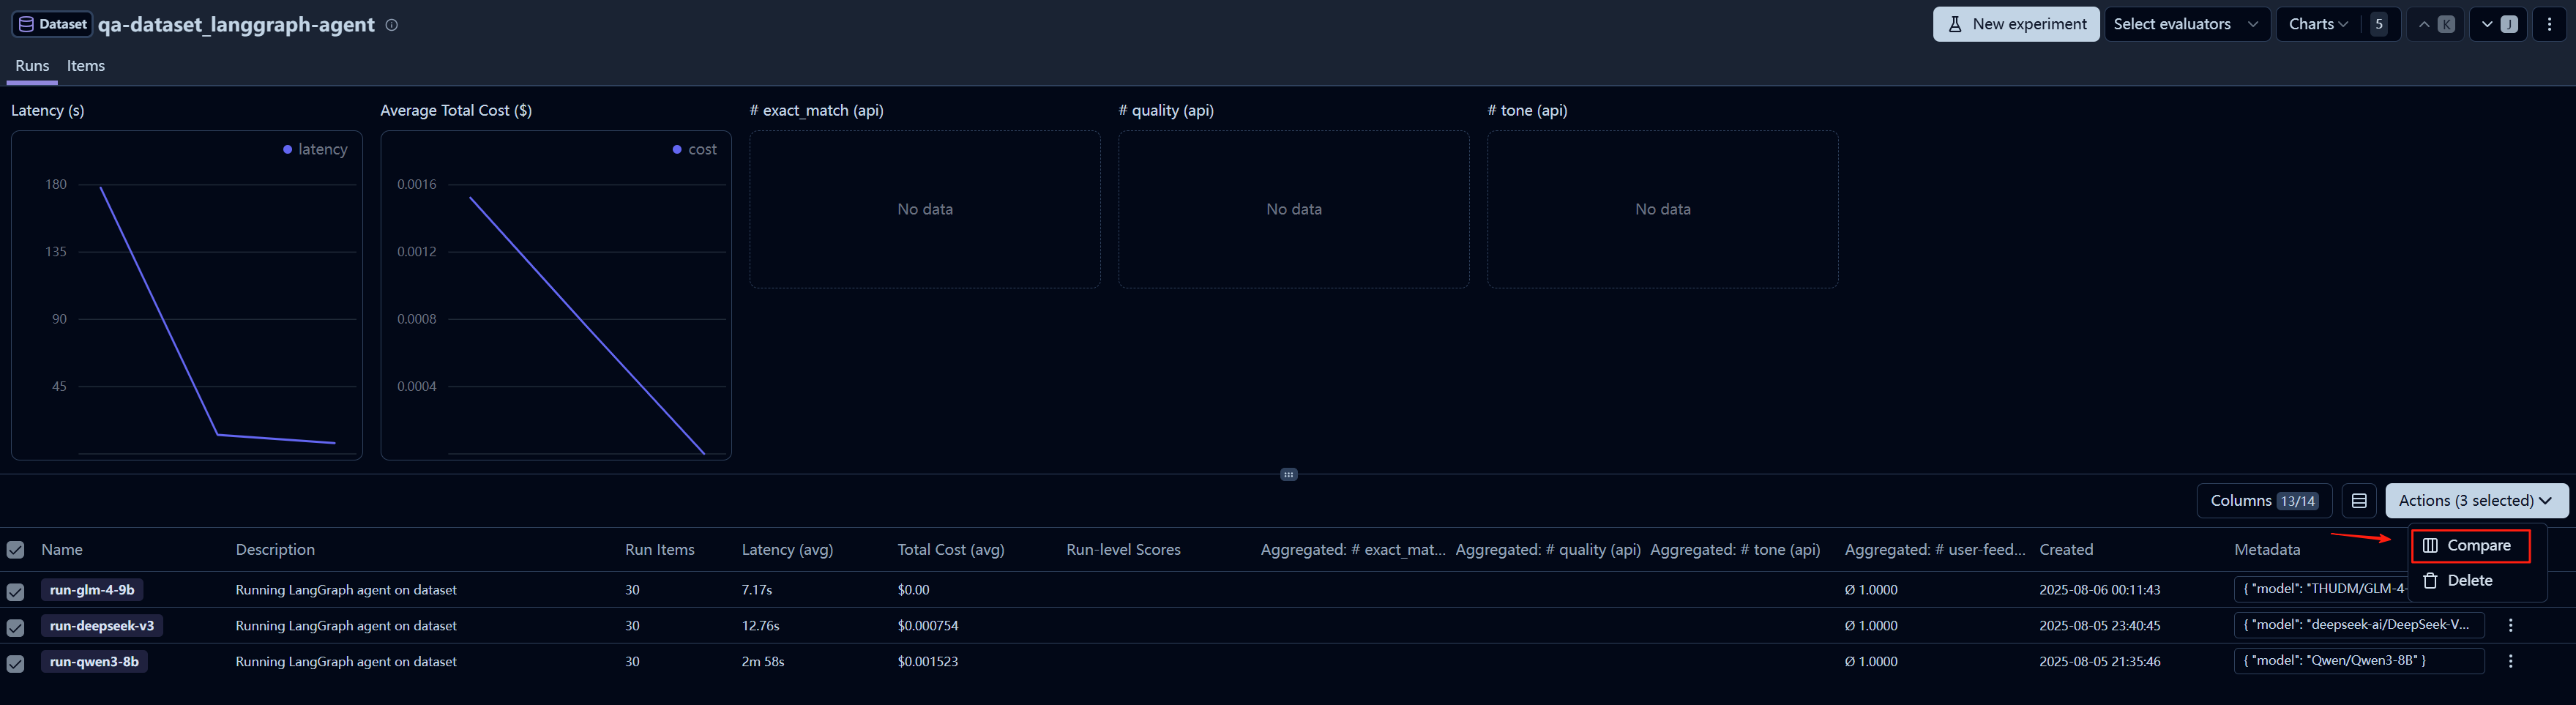


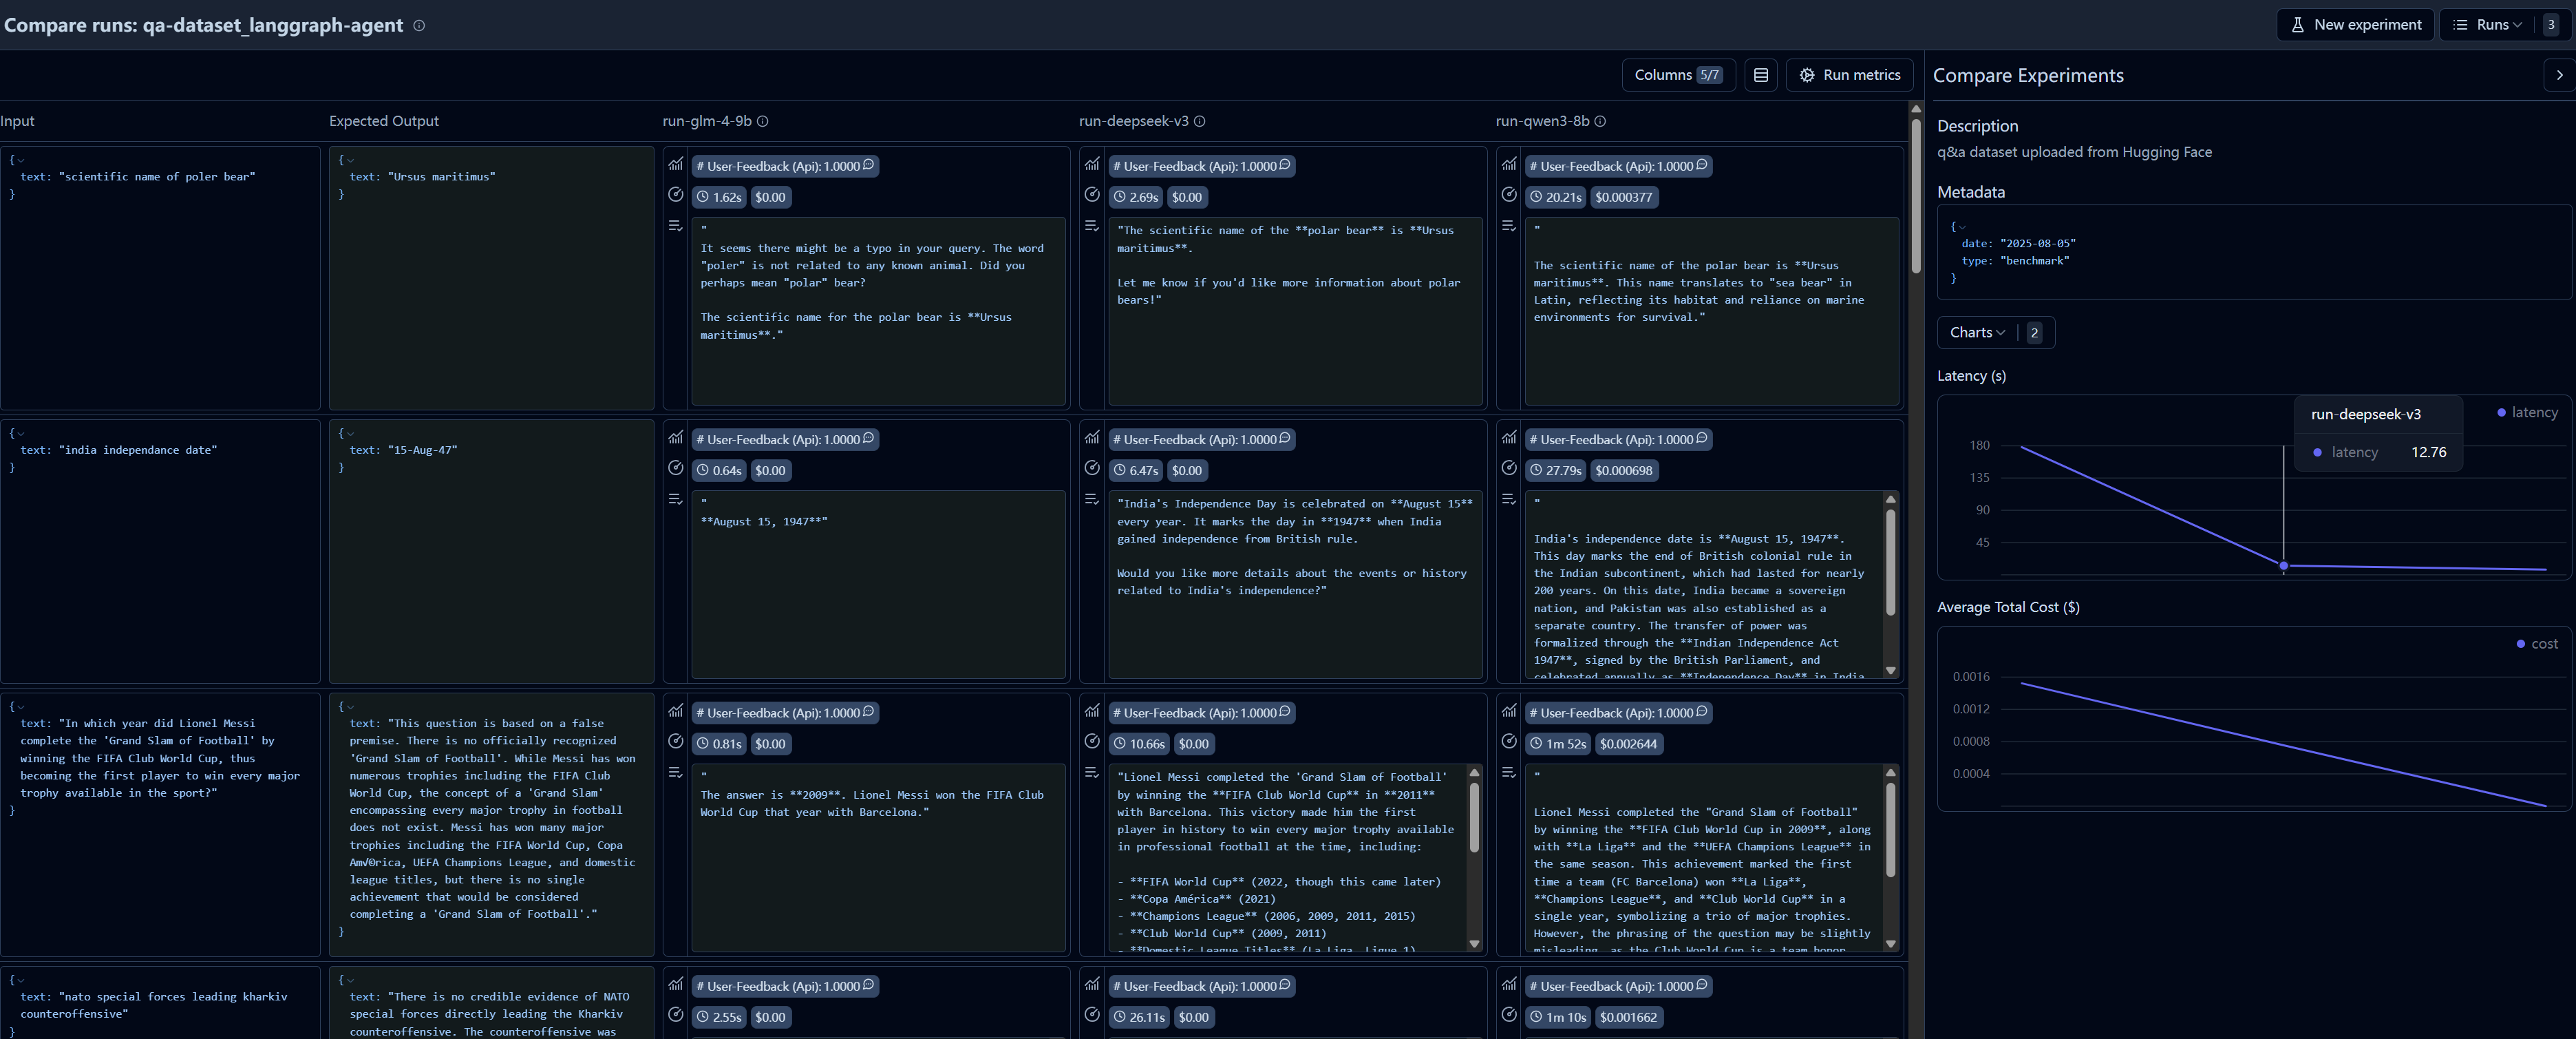


You can repeat this process with different agent configurations such as:

- Models (gpt-4o-mini, o1, etc.)
- Prompts
- Tools (search vs. no search)
- Complexity of agent (multi agent vs single agent)

Then compare them side-by-side in Langfuse. In this example, I did run the agent 3 times on the 30 dataset questions. For each run, I used a different OpenAI model. You can see that amount of correctly answered questions improves when using a larger model (as expected). The correct_answer score is created by an LLM-as-a-Judge Evaluator that is set up to judge the correctness of the question based on the sample answer given in the dataset.


#### OpenAI Agents SDK Dataset Experiment


#### CrewAI Dataset Experiment ([Dataset Experiments](https://langfuse.com/integrations/frameworks/crewai#dataset-experiments))

Offline evaluation using datasets is a critical part of the LLM development lifecycle. Langfuse supports this through Dataset Experiments. The typical workflow involves:

1. Benchmark Dataset: Defining a dataset with input prompts and their corresponding expected outputs.
2. Application Run: Running your LLM application against each item in the dataset.
3. Evaluation: Comparing the generated outputs against the expected results or using other scoring mechanisms (e.g., model-based evaluation) to assess performance.

The following example demonstrates how to use a pre-existing dataset containing development tasks to run an experiment with your CrewAI application.


In [23]:
from langfuse import get_client

langfuse = get_client()

# Fetch an existing dataset
dataset = langfuse.get_dataset(name="capital_cities")

for item in dataset.items:

    print(
        f"Item id: {item.id}, Input: {item.input["country"]}, Expected Output: {item.expected_output}"
    )

    # You can also access the trace_id if needed
    # print(f"Trace ID: {item.item_id}")

Item id: b9392b12-4842-4ac8-b9c3-3efc7fc8d436, Input: Egypt, Expected Output: Cairo
Item id: 5e97801f-3b68-4160-8124-78f92b1f0a68, Input: South Africa, Expected Output: Pretoria
Item id: ea394162-1830-4773-9a54-52296f69085e, Input: Argentina, Expected Output: Buenos Aires
Item id: 93f863cd-ae75-4876-8353-1cd7fbe46f3c, Input: South Korea, Expected Output: Seoul
Item id: ee19e470-b59d-4d4f-a68f-4cbf0c282079, Input: Canada, Expected Output: Ottawa
Item id: 1ea5c2fc-5ced-4f2e-83e8-4205aa08daba, Input: India, Expected Output: New Delhi
Item id: 2b52b2eb-f062-4db9-8035-42ed2a5674ee, Input: Japan, Expected Output: Tokyo
Item id: 6e74a1d2-ceb1-4c9e-916e-891f969a8a6a, Input: Brazil, Expected Output: Brasília
Item id: e97d71b9-eefe-45f4-aac9-b3f02a432e6c, Input: Spain, Expected Output: Madrid
Item id: 25aefca3-3dc0-4cd7-a794-bd6d5749beba, Input: Italy, Expected Output: Rome


Next, we iterate through each item in the dataset, run our CrewAI application (your_application) with the item’s input, and log the results as a run associated with that dataset item in Langfuse. This allows for structured evaluation and comparison of different application versions or prompt configurations.

The item.run() context manager is used to create a new trace for each dataset item processed in the experiment. Optionally you can score the dataset runs.


In [19]:
%pip install langfuse crewai openinference-instrumentation-crewai openinference-instrumentation-litellm

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
     - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
     - -------------------------------------- 0.3/8.7 MB ? eta -:--:--
     --- ------------------------------------ 0.8/8.7 MB 907.1 kB/s eta 0:00:09
     ---- ----------------------------------- 1.0/8.7 MB 1.0 MB/s eta 0:00:08
     ----- ---------------------------------- 1.3/8.7 MB 1.0 MB/s eta 0:00:08
     ------- -------------------------------- 1.6/8.7 MB 1.0 MB/s eta 0:00:07
     ------- -------------------------------- 1.6/8.7 MB 1.0 MB/s eta 0:00:07
     ------- -------------------------------- 1.6/8.7 MB 1.0 MB/s eta 0:00:07
     ------- -------------------------------- 1.6/8.7 MB 1.0 MB/s eta 0:00:07
     ------- -------------------------------- 1.6/8.7 MB 1.0 MB/s eta 0:00:07
     ------- ----------------

In [24]:
import os
from crewai import Agent, Task, Crew

# 配置环境变量让 CrewAI 自动使用 Ollama
os.environ["OPENAI_API_KEY"] = "ollama"  # 占位符，CrewAI 需要这个变量存在
os.environ["OPENAI_API_BASE"] = "http://localhost:11434"  # Ollama 的 API 端点
os.environ["OPENAI_MODEL_NAME"] = "ollama/qwen3:30b"  # 指定要使用的 Ollama 模型

# 或者设置 CrewAI 特定的环境变量
# os.environ["CREWAI_LLM_PROVIDER"] = "ollama"
# os.environ["CREWAI_MODEL"] = "qwen3:30b"

dataset_name = "capital_cities"
current_run_name = "dev_tasks_run-ollama_01"
current_run_metadata = {"model_provider": "ollama", "model": "qwen3:30b"}
current_run_description = "Evaluation run for Ollama model on August 7th, 2025"

# 你的应用函数保持不变，不需要在 Agent 中添加 llm 参数
def your_application(country):
    with langfuse.start_as_current_span(name="crewai-trace") as span:
        try:
            print(f"Processing country: {country}")
            
            # Agent 配置保持原样，CrewAI 会自动使用环境变量中的 LLM 配置
            geography_expert = Agent(
                role="Geography Expert",
                goal="Answer questions about geography",
                backstory="A geography expert with a keen eye for details.",
                llm=ChatOpenAI(
                    api_key=os.environ.get("OPENAI_API_KEY"),  
                    base_url=os.environ.get("OPENAI_API_BASE"),
                    model=os.environ.get("OPENAI_MODEL_NAME"),
                )
            )

            # Create tasks for your agents
            task1 = Task(
                description=f"What is the capital of {country}? Answer with just the city name.",
                expected_output="The name of the capital in one word",
                agent=geography_expert,
            )

            # Instantiate your crew(创建 Crew，管理 agent 和任务)
            crew = Crew(
                agents=[geography_expert],
                tasks=[task1],
                verbose=False  # 减少输出
            )

            # Run the crew
            result = crew.kickoff()
            result_str = str(result).strip() if result else "No result"
            print(f"✅ Result for {country}: {result_str}")

            # Update the trace with input and output
            span.update_trace(input=task1.description, output=result_str)
            return result_str
            
        except Exception as e:
            error_msg = f"❌ Error processing {country}: {str(e)}"
            print(error_msg)
            span.update_trace(input=f"Error for {country}", output=error_msg)
            return error_msg

# 运行实验
dataset = langfuse.get_dataset(name=dataset_name)

for item in dataset.items:
    print(f"Running evaluation for item: {item.id} (Input: {item.input})")

    with item.run(
        run_name=current_run_name,
        run_metadata=current_run_metadata,
        run_description=current_run_description,
    ) as root_span:
        generated_answer = your_application(
            country=item.input["country"],
        )
        
        # 评分逻辑
        if item.expected_output and item.expected_output.lower() in generated_answer.lower():
            root_span.score_trace(name="exact_match", value=1.0)
            print(f"   ✅ MATCH: Found '{item.expected_output}' in '{generated_answer}'")
        else:
            root_span.score_trace(name="exact_match", value=0.0)
            print(f"   ❌ NO MATCH: Expected '{item.expected_output}', Got '{generated_answer}'")

print(f"\nFinished processing dataset '{dataset_name}' for run '{current_run_name}'.")
langfuse.flush()

Running evaluation for item: b9392b12-4842-4ac8-b9c3-3efc7fc8d436 (Input: {'country': 'Egypt'})
Processing country: Egypt
✅ Result for Egypt: Cairo
   ✅ MATCH: Found 'Cairo' in 'Cairo'
Running evaluation for item: 5e97801f-3b68-4160-8124-78f92b1f0a68 (Input: {'country': 'South Africa'})
Processing country: South Africa
✅ Result for South Africa: Pretoria
   ✅ MATCH: Found 'Pretoria' in 'Pretoria'
Running evaluation for item: ea394162-1830-4773-9a54-52296f69085e (Input: {'country': 'Argentina'})
Processing country: Argentina
✅ Result for Argentina: Buenos Aires
   ✅ MATCH: Found 'Buenos Aires' in 'Buenos Aires'
Running evaluation for item: 93f863cd-ae75-4876-8353-1cd7fbe46f3c (Input: {'country': 'South Korea'})
Processing country: South Korea
✅ Result for South Korea: Seoul
   ✅ MATCH: Found 'Seoul' in 'Seoul'
Running evaluation for item: ee19e470-b59d-4d4f-a68f-4cbf0c282079 (Input: {'country': 'Canada'})
Processing country: Canada
✅ Result for Canada: Ottawa
   ✅ MATCH: Found 'Ottawa' 

[one trace url](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=ada087882723b39000e64a1152e9ab16&timestamp=2025-08-07T13%3A46%3A21.772Z)

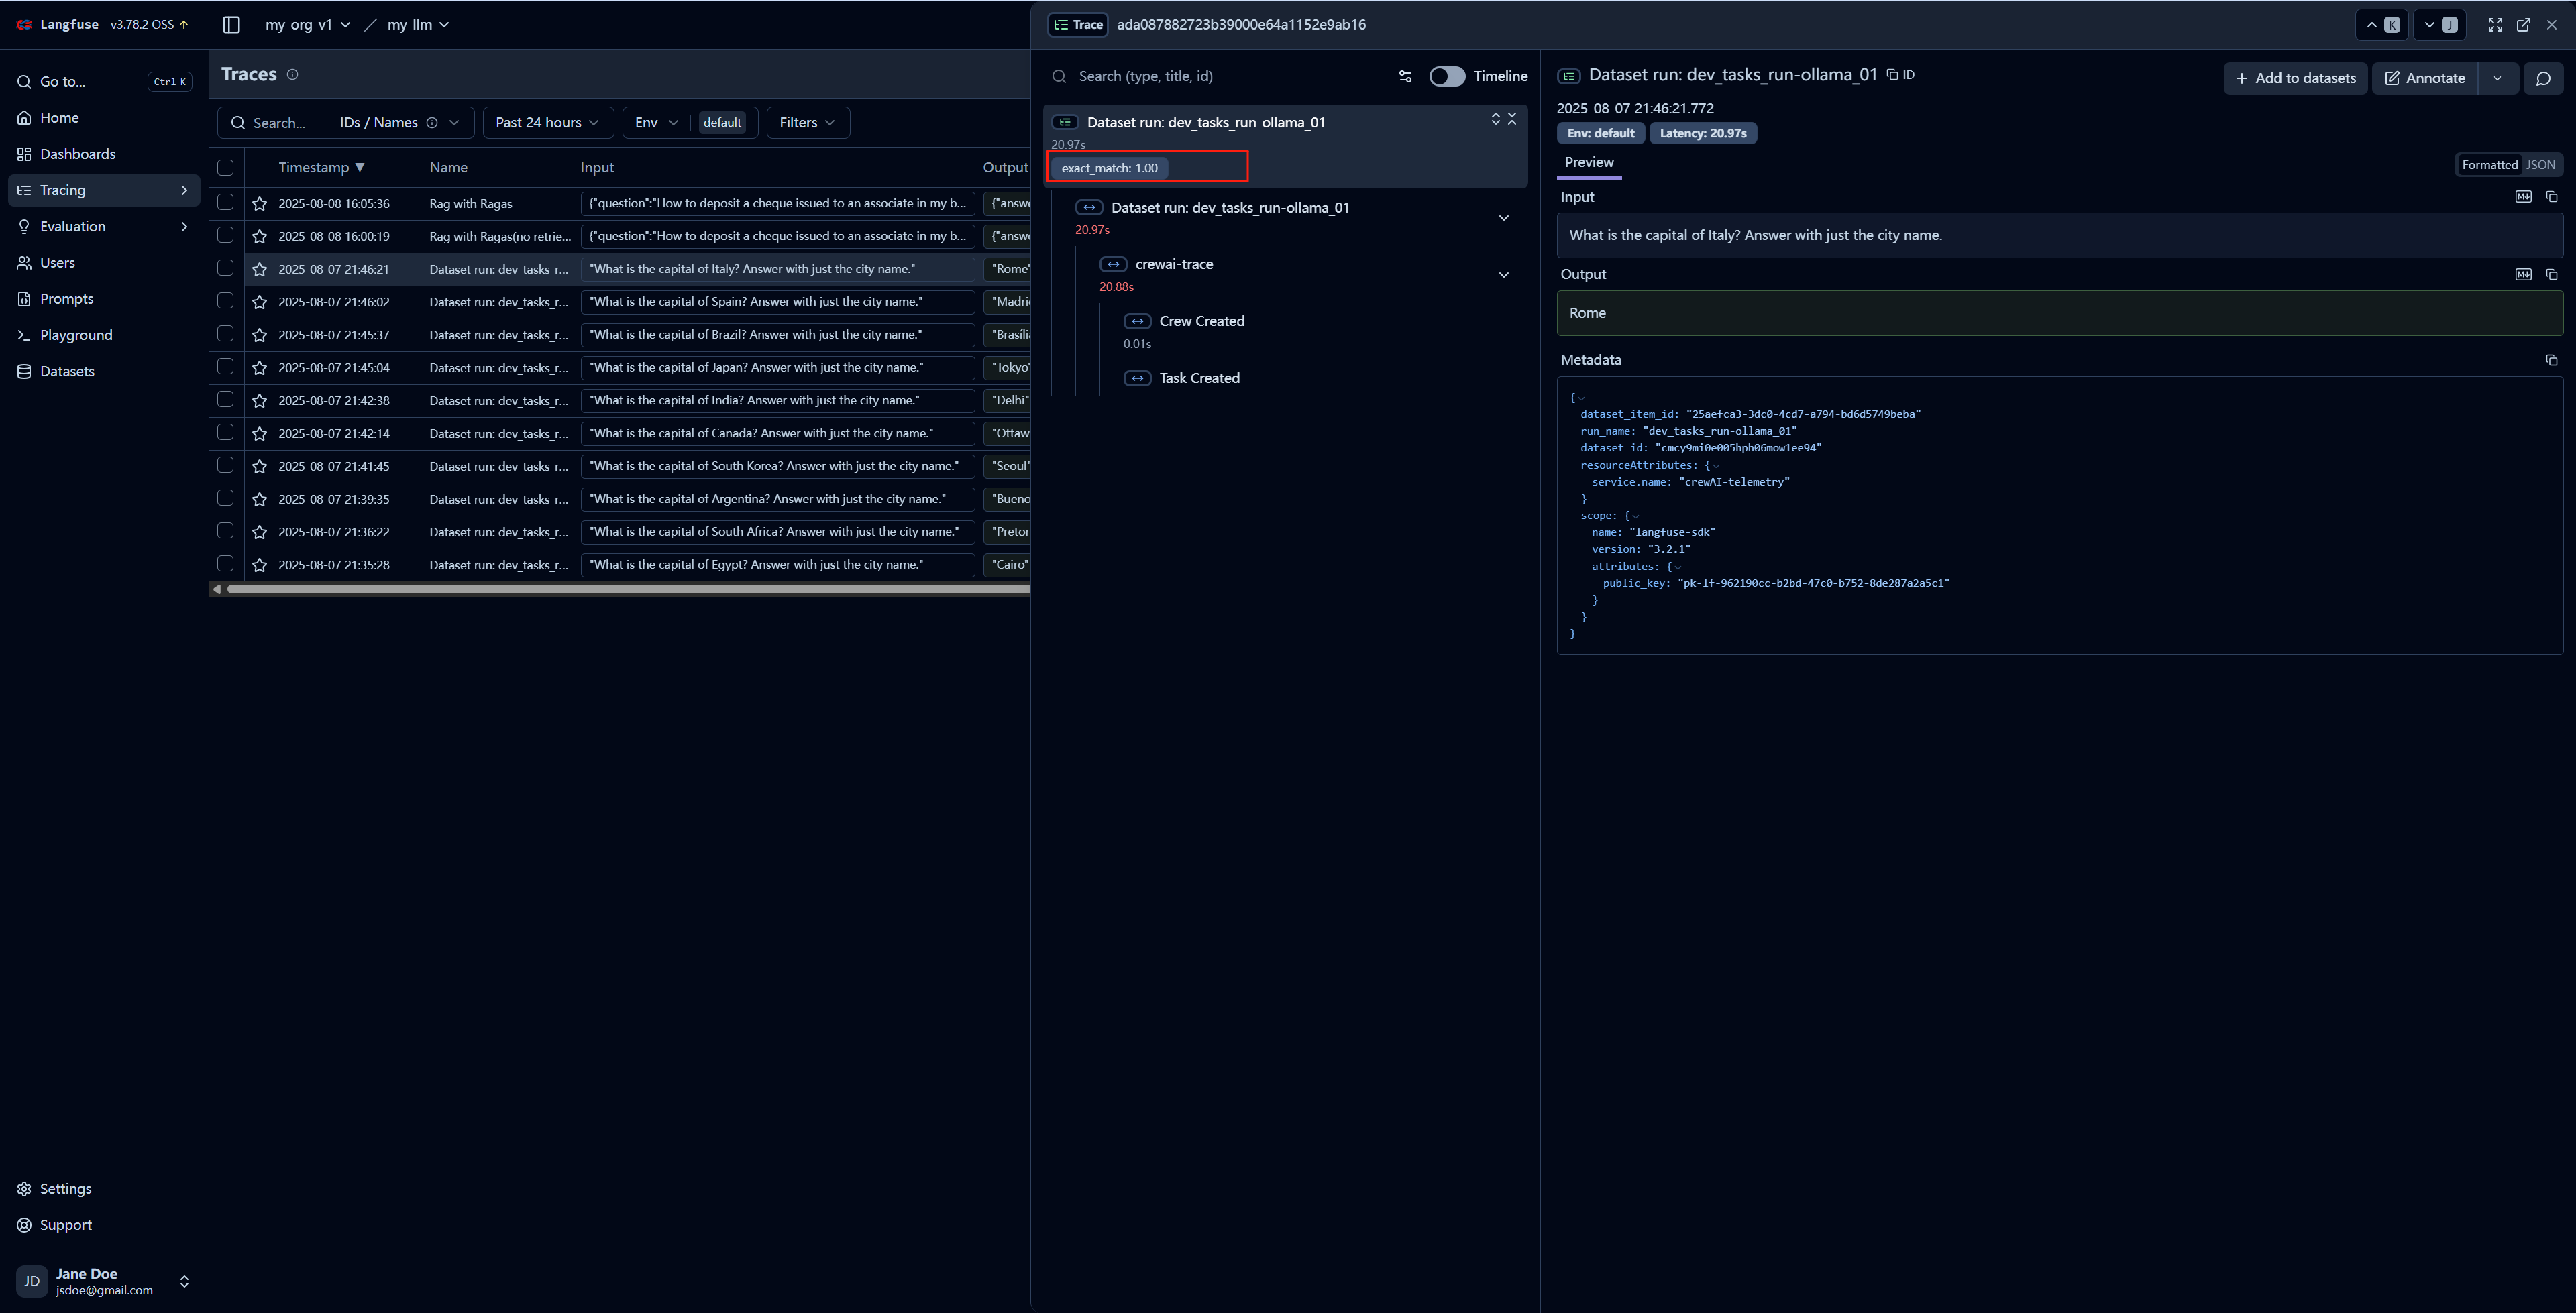